# Adamy Valuation - Michigan Data Science Team
### Michael Xinyu Tim Sid Derek Manny
                                                                                                        5/06/2017

**Purpose:** This notebook describes the data processing pipeline we have built and instructions on how to interpret the results.  
  
**Conclusion:** Ebitda/interest_exp is the best predictor of ev/ebidta. It seems that the higher the ebitda/interest_exp the lower our prediction for ev/ebitda. Other important features are ebitda_margin and ebitda.  
  
**Notes:** It was hard to precisely quantify the degree to which these variables actually impacted ev/ebitda because of the limitations of linear regression. We have provided several lists of features that our models found to be important. It would be interesting to compare and contrast these lists with the existing literature. 

## Load Libraries

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from get_data import *

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats
import random
from mpl_toolkits.mplot3d import Axes3D
from get_data import *

# SciKit Learn Modules
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [124]:
np.random.seed(0)
raw_data_frame = load_data_frames()
sectors = ['consumerDiscrete', 'consumerStaples', 'industrials']

Our exploratory data anlaysis led us to discover that our models would be more effective after transforming some of the columns. Specifically those columns that represent monetary values as well as a few others.

In [125]:
for i in range(len(raw_data_frame[0].columns)):
    print(i, raw_data_frame[0].columns[i])

(0, 't_ev')
(1, 't_rev')
(2, 'ebitda')
(3, 'ebitda_margin')
(4, 't_ev/t_rev')
(5, 't_ev/ebitda')
(6, 'est_ann_rev_gr_1yr')
(7, 'est_ann_ebitda_gr_1yr')
(8, 't_rev_1yr_growth')
(9, 'ebitda_1yr_growth')
(10, 't_rev_3_yr_cagr')
(11, 'ebitda_3yr_cagr')
(12, 't_rev_5yr_cagr')
(13, 'ebitda_5yr_cagr')
(14, 'return_on_assets')
(15, 'return_on_equity')
(16, 'capex_as_percent_rev')
(17, 'ebitda/interest_exp')
(18, 't_debt/cap_percent')
(19, 't_debt/equity_percent')


In [126]:
log_transform_columns =  [0, 1, 2, 5, 16, 17, 18, 19]
log_transform_col_names = []
for col in log_transform_columns:
    log_transform_col_names.append(raw_data_frame[0].columns[col])
print log_transform_col_names

['t_ev', 't_rev', 'ebitda', 't_ev/ebitda', 'capex_as_percent_rev', 'ebitda/interest_exp', 't_debt/cap_percent', 't_debt/equity_percent']


We need to actually modify the data for the columns we discovered.  
**Note:** Because we do the following process in place it is important that the line is not run twice.

In [127]:
# log-transform inplace
for i in range(len(sectors)):
    raw_data_frame[i][log_transform_col_names] = raw_data_frame[i][log_transform_col_names].apply(np.log10)
    raw_data_frame[i].rename(columns = {
        't_ev':'log_t_ev',
        't_rev':'log_t_rev',
        'ebitda':'log_ebitda',
        't_ev/ebitda':'log_t_ev/ebitda',
        'capex_as_percent_rev':'log_capex_as_percent_rev',
        'ebitda/interest_exp':'log_ebitda/interest_exp',
        't_debt/cap_percent':'log_t_debt/cap_percent',
        't_debt/equity_percent':'log_t_debt/equity_percent'
                                },inplace = True)    

In order to handle missing data we fill in cells the with mean for the column

In [128]:
for i in range(len(sectors)):
    raw_data_frame[i].fillna(raw_data_frame[i].mean(), inplace=True)

## Prepare the data for ML models

- Target: 't_ev/ebitda'
- Discard 't_ev'

From pearson correlation heatmap, we see that target variable is not strongly linearly associated with other features. Therefore, the nonlinear methods, like tree-based methods, or SVM with nonlinear kernels will outperform. However, one thing to notice is that our final goal is not to predict the target value but rather to understand the complex relationship between ev/ebitda and other features. We shall try various methods  
  
We chose to discared the feature t_ev and t_ev/t_rev because we believe it will not be known for a private company

In [129]:
# drop 't_ev' columns
for i in range(len(sectors)):
    raw_data_frame[i].drop('log_t_ev', axis=1, inplace=True)
    raw_data_frame[i].drop('t_ev/t_rev', axis=1, inplace=True)

In [130]:
print("Let's look at " + sectors[0])
cur_df = raw_data_frame[0]

Let's look at consumerDiscrete


In [131]:
y = cur_df['log_t_ev/ebitda']
X = cur_df.drop('log_t_ev/ebitda', axis=1)
X.head()

,log_t_rev,log_ebitda,ebitda_margin,est_ann_rev_gr_1yr,est_ann_ebitda_gr_1yr,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,log_capex_as_percent_rev,log_ebitda/interest_exp,log_t_debt/cap_percent,log_t_debt/equity_percent
0,3.075182,1.897077,6.64,4.540000,16.700000,2.06000,-0.852000,16.400000,19.400000,11.200000,18.700000,4.600000,9.900000,0.460898,1.103804,1.513218,1.685742
1,2.426511,0.772322,2.22,7.132813,17.742803,-1.93000,13.234825,-4.040000,-34.500000,-10.600000,-28.900000,-1.570000,-12.200000,0.444045,1.004171,1.561461,1.781483
2,3.509740,2.665393,14.30,1.480000,4.270000,4.08000,4.980000,13.000000,9.600000,10.300000,11.200000,9.930000,9.950000,0.278754,1.281033,1.489958,1.650308
3,3.531900,2.415808,7.65,-5.230000,-36.900000,-3.46000,-19.200000,-7.400000,-21.700000,-3.080000,-15.300000,1.560000,1.330000,0.609594,1.060698,1.311754,1.411620
4,3.191898,2.244277,11.30,7.132813,17.742803,331.70347,13.234825,12.670764,8.528391,8.063843,7.665472,6.344578,14.769923,0.187521,0.481443,1.857332,2.411114


It is common practice in Machine Learning to use inputs of mean = 0 and standard deviation = 1. This way the impact of the features can be compared head to head. The scale() function below does this transformation

In [132]:
from sklearn.preprocessing import scale
X_scale = scale(X)

Before we start doing any model selection it is important that we break our data up into a training and a test set. The training set will be used to select and train the models. The test set will come in at the end of the program and will be our way of testing a models accuracy on data that is has never seen.  
The training set will consist of 75% of our data and the test set will have the remaining 25%. Each set has an "X" and "y" component. The y component is what we are trying to predict, t_ev/ebitda. The X component consists of all other variables in the data set (ebitda, ebitda_margin, est_ann_rev_gr_1yr, etc.) which we will be using to predict t_ev/ebitda.

In [133]:
x_train, x_test, y_train, y_test = train_test_split(X_scale,y,train_size = 0.75)

In [134]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# ols_model = LinearRegression(normalize=True)
# scores = cross_val_score(ols_model, X_scale, y, cv=5, scoring="neg_mean_squared_error")

We start by trying two variations of Linear Regression. These variations are very common and are known as Lasso Regression and Ridge Regression. The basic idea is that by imposing certain penalties onto normal linear regression we can find a better model. However, inorder to find the optimal impact of the penatly term (alpha) we must test a series of options and choose the one that performs best. This procedure for doing this is called cross validation, a very common machine learning technique for selecting penalty terms and other "hyper parameters". 

Average MSE (alpha = 0.010): 0.0679 (+/- 0.0102)


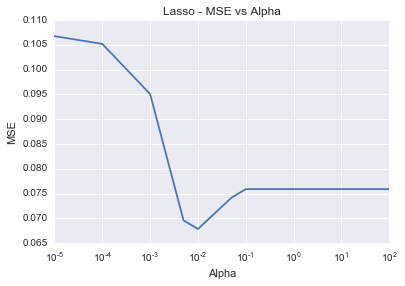

In [135]:
lasso_model = Lasso()
alphas         = [ 1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 10, 100 ]
lasso_mses     = []
lasso_avg_mses = []
lasso_std_mses = []

for alpha in alphas:
    lasso_model.alpha = alpha
    scores = cross_val_score(lasso_model, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
    lasso_mses.append( scores*-1 )
    lasso_avg_mses.append( -scores.mean() )
    lasso_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, lasso_avg_mses )
plt.title('Lasso - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

min_mse = min(lasso_avg_mses)
min_mse_index = lasso_avg_mses.index(min(lasso_avg_mses))
min_std_index = lasso_std_mses.index(min(lasso_std_mses))

if min_mse_index == min_std_index:
    best_index = min_mse_index
else:
    if abs(lasso_avg_mses[min_mse_index] - lasso_avg_mses[min_std_index]) < 0.01*lasso_avg_mses[min_mse_index]:
        best_index = min_std_index    
    else:
        best_index = min_mse_index
            
    
lasso_alpha = alphas[best_index]
print("Average MSE (alpha = %0.3f): %0.4f (+/- %0.4f)" % (alphas[best_index],lasso_avg_mses[best_index], lasso_std_mses[best_index]))

The whole purpose of the above is to find the optimal alpha (the penalty). For each different alpha the model has a different performance. In the plot above we are measuring the mean squared error of the model for each alpha we tested. The lower the error the better the alpha. Alpha in this case was selected to be 0.010  
  
Now we are going to perform the same cross validation procedue to find the optimal alpha for Ridge Regression.

Average MSE (alpha = 100.000): 0.0654 (+/- 0.0142)


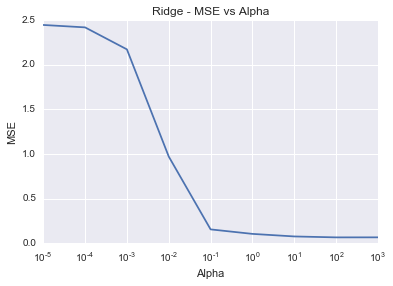

In [136]:
ridge_model = Ridge()
alphas         = [ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100,1000 ]
ridge_mses     = []
ridge_avg_mses = []
ridge_std_mses = []

for alpha in alphas:
    ridge_model.alpha = alpha
    scores = cross_val_score(ridge_model, X_scale, y, scoring='neg_mean_squared_error', cv=5)
    ridge_mses.append( scores*-1 )
    ridge_avg_mses.append( -scores.mean() )
    ridge_std_mses.append( scores.std() )

# Plot Hyperparameter Selection
plt.semilogx( alphas, ridge_avg_mses )
plt.title('Ridge - MSE vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')



min_mse = min(ridge_avg_mses)
min_mse_index = ridge_avg_mses.index(min(ridge_avg_mses))
min_std_index = ridge_std_mses.index(min(ridge_std_mses))

if min_mse_index == min_std_index:
    best_index = min_mse_index
else:
    if abs(lasso_avg_mses[min_mse_index] - lasso_avg_mses[min_std_index]) < 0.01*lasso_avg_mses[min_mse_index]:
        best_index = min_std_index    
    else:
        best_index = min_mse_index

ridge_alpha = alphas[best_index]        
# print('MSEs (alpha = 1e-2):', lasso_mses[3]*-1)
print("Average MSE (alpha = %0.3f): %0.4f (+/- %0.4f)" % (alphas[best_index],ridge_avg_mses[best_index], ridge_std_mses[best_index]))

For Ridge Regression we found the model performs best with an alpha = 100

### Training the Models
Now that we have determined what alpha level is best for both Lasso and Ridge regression we are ready to fit a model to our training data.

In [137]:
lasso_model = Lasso(alpha = lasso_alpha)
lasso_model.fit(x_train,y_train)
lasso_betas = lasso_model.coef_
lasso_pred = lasso_model.predict(x_test)

In [138]:
ridge_model = Ridge(alpha = ridge_alpha)
ridge_model.fit(x_train,y_train)
ridge_betas = ridge_model.coef_
ridge_pred = ridge_model.predict(x_test)

In [139]:
lasso_mse = metrics.mean_squared_error(y_true = y_test, y_pred = lasso_pred)
ridge_mse = metrics.mean_squared_error(y_true = y_test, y_pred = ridge_pred)
print "Lasso Mean Square Err:",lasso_mse
print "Ridge Mean Square Err:",ridge_mse

Lasso Mean Square Err: 0.0531800178845
Ridge Mean Square Err: 0.0579797624261


Both model seem to do fairly well. We aren't too concerned with the predictions because the Comps approach to market valuation is much more sophisticated and accurate. However, we can take a look at which features our models found to be most important by looking at the "beta" variables we stored above. Beta's are the coefficents in a linear regression model. There is one Beta for every feature (ebitda, ebitda_margin, est_ann_rev_gr_1yr, etc.) that we used in our model. Looking at the absolute value and ranking them will tell us which features had the biggest impact on prediction. 

In [140]:
lasso_beta_pairs = []
for i in range(len(lasso_betas)):
    lasso_beta_pairs.append((i,lasso_betas[i])) 
sorted_lasso_betas = sorted(lasso_beta_pairs, key=lambda x: abs(x[1]), reverse = True) 
for i in range(5):
    index = sorted_lasso_betas[i][0]
    print i+1, X.columns[index], round(sorted_lasso_betas[i][1],4)

1 log_ebitda/interest_exp -0.053
2 est_ann_rev_gr_1yr 0.0355
3 t_rev_5yr_cagr 0.0337
4 log_ebitda -0.0293
5 ebitda_margin -0.0195


Listed above are the top 5 most important features for predicting the log(t_ev/ebitda) according to lasso model. Because of all that preprocessing we did it is kind of hard to interpret what these numbers actually mean. The **important thing to notice** here is the **order in which the features are ranked and whether a feature is positive is negative.** According to lasso model log(ebitda/interest_exp) is the best predictor of t_ev/ebitda. The coefficent is also negative which means the larger our value of log(ebitda/interest_exp) the smaller our prediction for log(t_ev/ebitda) (I will explain the precise interpretation later). We also see that est_ann_rev_gr_1yr is the second best and t_rev_5yr_cargr is third and so on.

We repeat this process for the ridge model...

In [141]:
ridge_beta_pairs = []
for i in range(len(ridge_betas)):
    ridge_beta_pairs.append((i,ridge_betas[i])) 
sorted_ridge_betas = sorted(ridge_beta_pairs, key=lambda x: abs(x[1]), reverse = True) 
for i in range(5):
    index = sorted_ridge_betas[i][0]
    print i+1, X.columns[index], round(sorted_ridge_betas[i][1],4)

1 log_ebitda/interest_exp -0.0477
2 est_ann_rev_gr_1yr 0.0358
3 t_rev_5yr_cagr 0.0347
4 log_ebitda -0.0317
5 ebitda_1yr_growth -0.0233


According to our ridge regression model log(ebitda/interest_exp) is also our best predictor. Both lasso and ridge have similar features in their top 5 also the order was a bit different.

## Intrepretation

Standardizing our inputs gave us the ability to determine which model performed the best and which features were the most important but it made things hard to interpret. Now that we know what features to look at we are going to run a standard linear regression and interpret the coefficients

In [142]:
y = cur_df['log_t_ev/ebitda']
X = cur_df.drop('log_t_ev/ebitda', axis=1)
X.head()

,log_t_rev,log_ebitda,ebitda_margin,est_ann_rev_gr_1yr,est_ann_ebitda_gr_1yr,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,log_capex_as_percent_rev,log_ebitda/interest_exp,log_t_debt/cap_percent,log_t_debt/equity_percent
0,3.075182,1.897077,6.64,4.540000,16.700000,2.06000,-0.852000,16.400000,19.400000,11.200000,18.700000,4.600000,9.900000,0.460898,1.103804,1.513218,1.685742
1,2.426511,0.772322,2.22,7.132813,17.742803,-1.93000,13.234825,-4.040000,-34.500000,-10.600000,-28.900000,-1.570000,-12.200000,0.444045,1.004171,1.561461,1.781483
2,3.509740,2.665393,14.30,1.480000,4.270000,4.08000,4.980000,13.000000,9.600000,10.300000,11.200000,9.930000,9.950000,0.278754,1.281033,1.489958,1.650308
3,3.531900,2.415808,7.65,-5.230000,-36.900000,-3.46000,-19.200000,-7.400000,-21.700000,-3.080000,-15.300000,1.560000,1.330000,0.609594,1.060698,1.311754,1.411620
4,3.191898,2.244277,11.30,7.132813,17.742803,331.70347,13.234825,12.670764,8.528391,8.063843,7.665472,6.344578,14.769923,0.187521,0.481443,1.857332,2.411114


In [143]:
x_train, x_test, y_train, y_test = train_test_split(X,y,train_size = 0.75)

In [144]:
ols_model = LinearRegression()

In [145]:
ols_model.fit(X,y)
betas = ols_model.coef_

In [146]:
beta_pairs = []
for i in range(len(betas)):
    beta_pairs.append((i,ridge_betas[i])) 
    index = betas[i]
    # print i+1, X.columns[i], round(betas[i],7)

In [147]:
print 'log_ebitda/interest_exp', round(betas[14],4)
print 'est_ann_rev_gr_1yr', round(betas[3],4)
print 't_rev_5yr_cagr' , round(betas[9],4)
print 'log_ebitda', round(betas[1],4)
print 'ebitda_margin', round(betas[2],4)
print 'ebitda_1yr_growth', round(betas[6],4)

log_ebitda/interest_exp -0.1119
est_ann_rev_gr_1yr 0.0019
t_rev_5yr_cagr 0.0046
log_ebitda 0.0094
ebitda_margin -0.0016
ebitda_1yr_growth -0.0001


Looking at the six different variables that turned up from our models. The interpretation of the coefficient is as follows:    
  
**log_ebitda/interest_exp:**  
Holding the values for all other features constant, every unit increase we measure in the log_ebitda/interest_exp our prediction of the log(t_ev/ebitda) of to **decrease** by 0.1119 or the t_ev/ebitda to decrease by 10^0.1119 = 1.293 
  
**est_ann_rev_gr_1yr:**  
Holding the values of all other features constant, every unit increase we measure in the est_ann_rev_gr_1yr our prediction of the log(t_ev/ebitda) increases by 0.0019 or in other words our prediction of t_ev/ebitda increases by 10^0.0019 = 1.004  
  
The same interperation follows for all of these coefficients. I am not sure how useful the actual interpretations are because in the valuation setting there is no way to hold the other features constant. Atleast 3 or 4 features use ebitda and by changing one of those variables you inherently must change some of the others. There is one more method that may be able to exploit this inherent connection between features. It is known as random forest. It is a 'tree based method' I am not an expert on how it works (I will link a suitable explanation) but I know that it produces a list of what features were most important in its prediction. It cannot tell you whether a certain feature has a positive or negative impact on the prediction.

## Random Forest Classifier

In [148]:
# basic model 
model = RandomForestRegressor()
scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
# print('MSEs:', scores*-1)
print("Average MSE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std()))

Average MSE: 0.0520 (+/- 0.0169)


There are a bunch of 'tuning parameters' for random forest. One commonly used method is to just try a bunch of combinations and take the the one that works best.

In [149]:
from sklearn.ensemble import RandomForestRegressor
from itertools import product
n_estimators_params = [10, 20]
max_features_params = ['auto', 'sqrt', "log2"]
min_samples_split_params = [2]
min_samples_leaf_params = [  2]

result_dict = {}
for param in product(n_estimators_params, max_features_params, min_samples_split_params, min_samples_leaf_params):
    rf_model = RandomForestRegressor(n_estimators=param[0], max_features=param[1],
                                min_samples_split=param[2], min_samples_leaf=param[3], 
                                 random_state=1711, n_jobs=-1)
    scores = cross_val_score(rf_model, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
    result_dict[param] = (-scores.mean(), scores.std())
#     print 'current param: n_estimators_params, max_features_params, min_samples_split_params, min_samples_leaf_params'
#     print param
#     print 'mse mean and std: ',  -scores.mean(), scores.std()

In [150]:
min_mse = 100
min_param = ()
for param in result_dict:
    if result_dict[param][0] < min_mse:
        min_mse=result_dict[param][0]
        min_param = param
print result_dict[min_param], min_param

(0.047711707819577627, 0.01456937594212109) (20, 'auto', 2, 2)


We found that the optimal model uses 20 estimators, 'auto' feature parameters, and will split a minimum of 2 times and leave a minimum of 2 leafs. It is not useful to go into precise defintions of what these terms means. The implications are not clear. We want to focus on the feature importance that will come out as a result.

In [151]:
rf_model = RandomForestRegressor(n_estimators=20, max_features='auto',
                                min_samples_split=2, min_samples_leaf=2,random_state=1711, n_jobs=-1)
rf_model.fit(x_train, y_train)
yhat_rf = rf_model.predict(x_test)
#print 'Finished!'

In [152]:
feature_importance = rf_model.feature_importances_

In [153]:
rf_feat_pairs = []
for i in range(len(feature_importance)):
    rf_feat_pairs.append((i,feature_importance[i])) 
sorted_feat_pairs = sorted(rf_feat_pairs, key=lambda x: abs(x[1]), reverse = True) 
for i in range(5):
    index = sorted_feat_pairs[i][0]
    print i+1, X.columns[index], round(sorted_feat_pairs[i][1],4)

1 log_ebitda/interest_exp 0.1721
2 ebitda_margin 0.104
3 log_ebitda 0.0983
4 t_rev_3_yr_cagr 0.0938
5 return_on_assets 0.0923


We see again log_ebitda/interest_exp is at the top of the list. There are a few shared features as well such as ebitda_margin, and log_ebitda.